In [337]:
import os
import cv2
import torch
import kornia
import copy
import random
import struct
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from typing import Tuple
from datetime import datetime
from skimage.io import imread
from skimage.transform import resize
from scipy.stats import ttest_rel
from model import create_model
from metrics import overall_accuracy, precision, recall, jacc_coef

plt.rcParams.update({'font.family': 'Times New Roman'})

# Load model and weights

In [398]:
model = create_model((384, 384), 4, 64)

In [295]:
MODEL_WEIGHTS = [
    'weights/weights-24-01-13-18-11.hdf5',
    'weights/model-weights-iteration1-batchsize-16-24-01-13-23-22.hdf5',
    'weights/model-weights-iteration1-batchsize-16-24-01-14-02-33.hdf5',
    'weights/model-weights-iteration1-batchsize-16-24-01-14-05-12.hdf5',
    'weights/model-weights-iteration1-batchsize-16-24-01-14-07-50.hdf5',
    'weights/bc-model-weights-iteration-1-batchsize-8-24-01-14-13-54.hdf5',
]

# Load the testing images

In [314]:
with open('image_names.csv', 'r') as f:
    image_names = [x.strip() for x in f.readlines()[1:]]

In [315]:
files = []
for image_name in image_names:
    img = imread(f'images/{image_name}') / 255
    msk = imread(f'masks/{image_name}') / 255
    files.append([img.astype(np.float32), msk.astype(np.float32)])

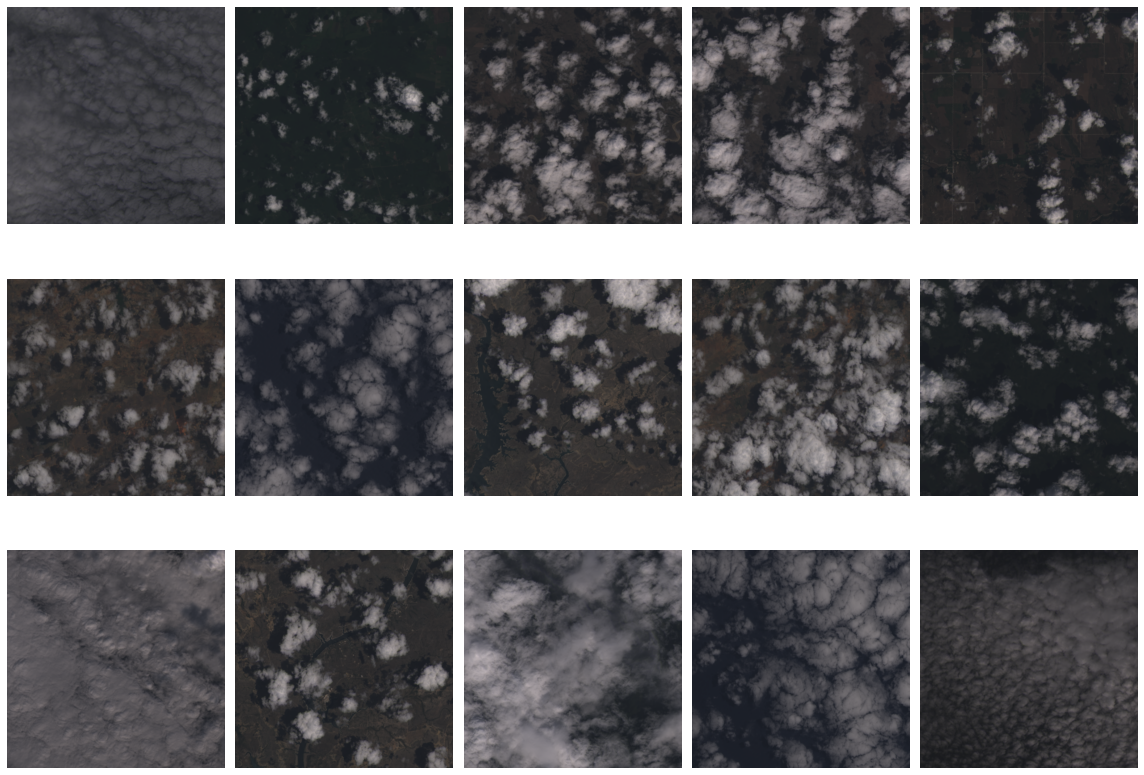

In [316]:
fig, ax = plt.subplots(3, 5, figsize=(16, 12))
ax = ax.flatten()

for i, file in enumerate(files):
    ax[i].imshow(file[0][:, :, :3])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

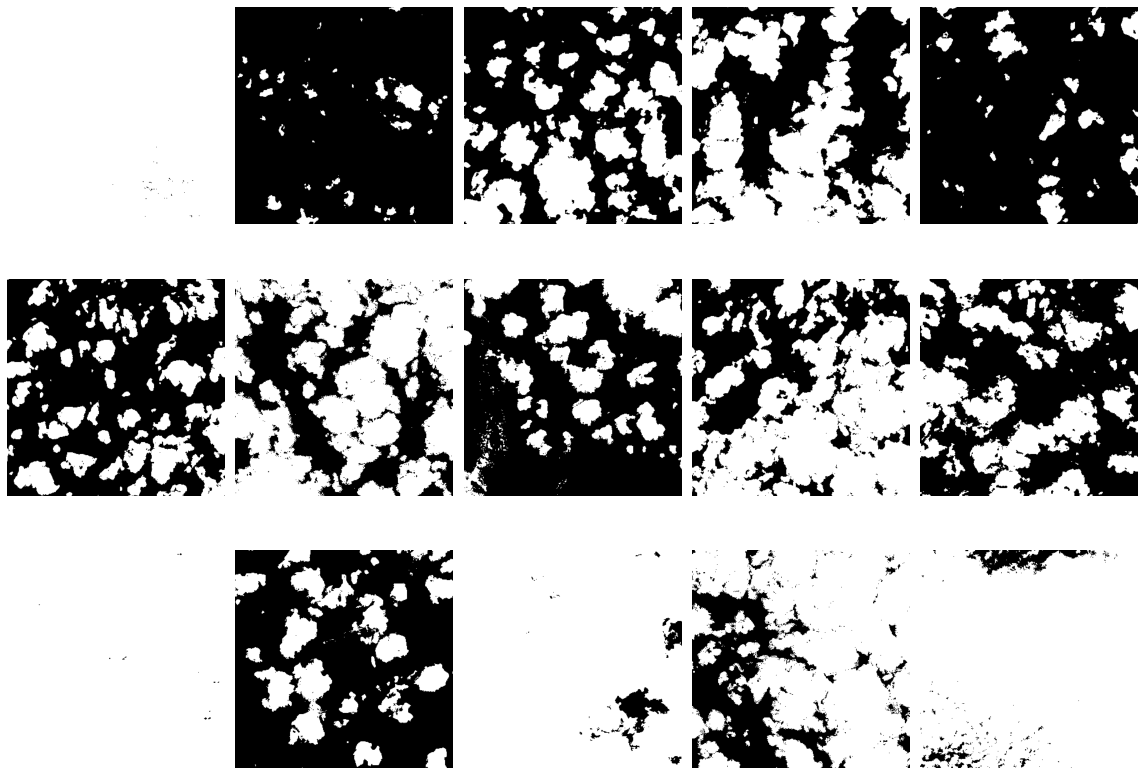

In [317]:
fig, ax = plt.subplots(3, 5, figsize=(16, 12))
ax = ax.flatten()

for i, file in enumerate(files):
    ax[i].imshow(file[1][:, :, :1], cmap='gray')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Baseline model test

For the validation validation, a separate validation set was selected randomly. It contains about 20% of all data

In [395]:
validation_files = []

with open('validation_image_names.csv', 'r') as f:
    content = [x.strip() for x in f.readlines()[1:]]

for l in content:
    img = imread(f'validation_images/{l}') / 255
    img = resize(img, (192, 192), preserve_range=True, mode='symmetric').astype(np.float32)
    
    msk = imread(f'validation_masks/{l}') / 255
    msk = resize(msk, (192, 192), preserve_range=True, mode='symmetric')
    msk = np.where(msk < 0.5, 0, 1).astype(np.float32)
    
    validation_files.append([img, msk])

In [396]:
model_accuracies = []
model_precisions = []
model_recalls = []

for weights in MODEL_WEIGHTS:
    model.load_weights(weights)
    accuracies = []
    precisions = []
    recalls = []
    for i in range(len(validation_files)):
        img = validation_files[i][0]
        mask = validation_files[i][1]
        
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        prediction = model.predict(img)
        
        accuracies.append(overall_accuracy(mask[:, :, 0], prediction[0, :, :, 0]))
        precisions.append(precision(mask[:, :, 0], prediction[0, :, :, 0]))
        recalls.append(recall(mask[:, :, 0], prediction[0, :, :, 0]))
    
    model_accuracies.append(np.mean(accuracies))
    model_precisions.append(np.mean(precisions))
    model_recalls.append(np.mean(recalls))

/Users/kevinlange/miniforge3/envs/AI/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kevinlange/miniforge3/envs/AI/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


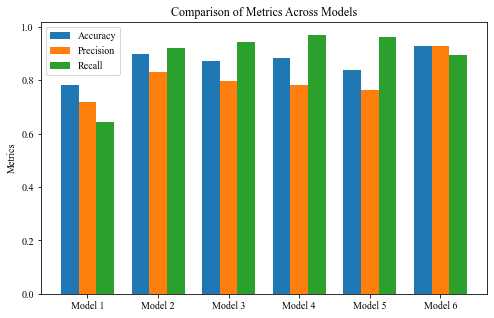

In [349]:
bar_width = 0.25

x_accuracy = np.arange(len(MODEL_WEIGHTS))
x_precision = [x + bar_width for x in x_accuracy]
x_recall = [x + bar_width for x in x_precision]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x_accuracy, model_accuracies, width=bar_width, label='Accuracy')
ax.bar(x_precision, model_precisions, width=bar_width, label='Precision')
ax.bar(x_recall, model_recalls, width=bar_width, label='Recall')

ax.set_ylabel('Metrics')
ax.set_title('Comparison of Metrics Across Models')
ax.set_xticks([x + bar_width for x in range(len(MODEL_WEIGHTS))])
ax.set_xticklabels([f'Model {i + 1}' for i in range(len(MODEL_WEIGHTS))])
plt.legend()
plt.savefig('baseline.pdf')
plt.show()

## Exemplary output

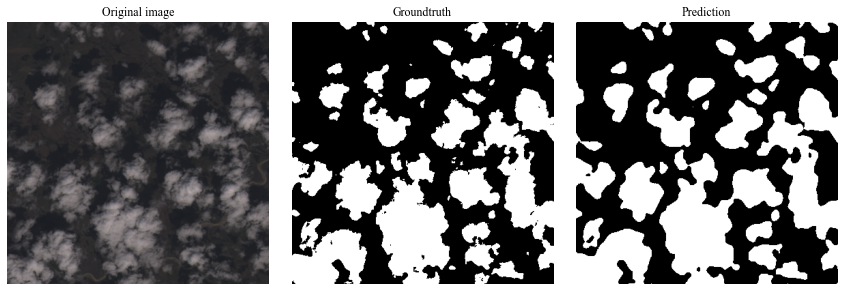

In [400]:
model.load_weights(MODEL_WEIGHTS[5])
img_idx = 2

img = files[img_idx][0].astype(np.float32)
img = img.reshape((1, 384, 384, 4))
prediction = model.predict(img)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(files[img_idx][0][:, :, :3])  # Change the colormap as needed
axes[0].set_title('Original image')
axes[0].axis('off')

axes[1].imshow(files[img_idx][1], cmap='gray')  # Change the colormap as needed
axes[1].set_title('Groundtruth')
axes[1].axis('off')

axes[2].imshow(np.where(prediction[0] < 0.5, 0, 1), cmap='gray')
axes[2].set_title('Prediction')
axes[2].axis('off')

plt.tight_layout()

plt.show()

# Apply filters to the images
- Use different image disturbances from Kornia
- Inject different radiation induced errors
- Apply dark current noise

## Kornia helper functions

In [401]:
def make_tensor(img_array):
    if not isinstance(img_array, np.ndarray):
        img_array = np.array(img_array)

    if np.max(img_array) > 1:
        img_array = img_array / 255
    
    return kornia.image_to_tensor(img_array).float().unsqueeze(0)

def make_image(tensor):
    return kornia.tensor_to_image(tensor.squeeze().byte())

## Hot Pixels

In [402]:
def hot_pixels(image, n_pixels=30):
    pixelated_image = np.copy(image)
    for _ in range(n_pixels):
        x = int(np.random.uniform(0, image.shape[0] - 1))
        y = int(np.random.uniform(0, image.shape[1] - 1))

        pixelated_image[x, y] = 1.
    return pixelated_image

In [403]:
results = open('hot_pixels.csv', 'w')
results.write('model,file,hotpixels,accuracy,precision,recall\n')

for weights in MODEL_WEIGHTS:
    print("[I] Start with weights:", weights)
    model.load_weights(weights)
    
    for file_idx, file in enumerate(files):
        mask = file[1]
        
        for i in range(50):
            img = copy.deepcopy(file[0])
            disturbed_img = hot_pixels(img, i)
            prediction = model.predict(disturbed_img.reshape((1, 384, 384, 4)))
            prec = precision(mask, prediction)
            rec = recall(mask, prediction)
            acc = overall_accuracy(mask, prediction)
            
            results.write(f'{weights},{image_names[file_idx]},{i},{acc},{prec},{rec}\n')
            
results.close()

[I] Start with weights: weights/weights-24-01-13-18-11.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-13-23-22.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-14-02-33.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-14-05-12.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-14-07-50.hdf5
[I] Start with weights: weights/bc-model-weights-iteration-1-batchsize-8-24-01-14-13-54.hdf5


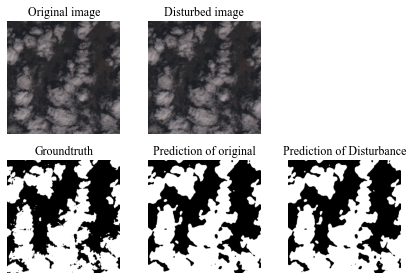

In [422]:
fig, axes = plt.subplots(2, 3)

model.load_weights(MODEL_WEIGHTS[5])

img, mask = files[3]
disturbed_img = hot_pixels(img, 100)
og_prediction = model.predict(img.reshape((1, 384, 384, 4)))
prediction = model.predict(disturbed_img.reshape((1, 384, 384, 4)))

axes[0, 0].imshow(img[:, :, :3])
axes[0, 0].set_title('Original image')
axes[0, 0].axis('off')

axes[0, 1].imshow(disturbed_img[:, :, :3])  # Change the colormap as needed
axes[0, 1].set_title('Disturbed image')
axes[0, 1].axis('off')

# Hiding the empty subplot in the second row
axes[0, 2].axis('off')

axes[1, 0].imshow(mask, cmap='gray')  # Change the colormap as needed
axes[1, 0].set_title('Groundtruth')
axes[1, 0].axis('off')

axes[1, 1].imshow(np.where(og_prediction[0] < 0.5, 0, 1), cmap='gray')
axes[1, 1].set_title('Prediction of original')
axes[1, 1].axis('off')

axes[1, 2].imshow(np.where(prediction[0] < 0.5, 0, 1), cmap='gray')
axes[1, 2].set_title('Prediction of Disturbance')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('Hot_pixels.pdf', dpi=600)
plt.show()

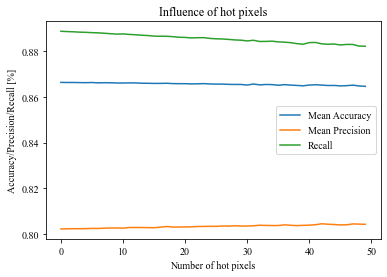

In [417]:
df = pd.read_csv("hot_pixels.csv", sep=",")
df = df[['hotpixels','accuracy','precision','recall']].groupby('hotpixels').mean().reset_index()

plt.figure()
plt.plot(df['accuracy'], label='Mean Accuracy')
plt.plot(df['precision'], label='Mean Precision')
plt.plot(df['recall'], label='Recall')
plt.title("Influence of hot pixels")
plt.xlabel("Number of hot pixels")
plt.ylabel("Accuracy/Precision/Recall [%]")
plt.legend()
plt.savefig('hotpixels.pdf', dpi=600)
plt.show()

## Black pixels

In [418]:
def black_pixels(image, n_pixels=30):
    pixelated_image = np.copy(image)
    for _ in range(n_pixels):
        x = int(np.random.uniform(0, image.shape[0] - 1))
        y = int(np.random.uniform(0, image.shape[1] - 1))

        pixelated_image[x, y] = 0.
    return pixelated_image

In [419]:
results = open('black_pixels.csv', 'w')
results.write('model,file,blackpixels,accuracy,precision,recall\n')

for weights in MODEL_WEIGHTS:
    print("[I] Start with weights:", weights)
    model.load_weights(weights)
    
    for file_idx, file in enumerate(files):
        mask = file[1]
        
        for i in range(50):
            img = copy.deepcopy(file[0])
            disturbed_img = black_pixels(img, i)
            prediction = model.predict(disturbed_img.reshape((1, 384, 384, 4)))
            prec = precision(mask, prediction)
            rec = recall(mask, prediction)
            acc = overall_accuracy(mask, prediction)
            
            results.write(f'{weights},{image_names[file_idx]},{i},{acc},{prec},{rec}\n')
            
results.close()

[I] Start with weights: weights/weights-24-01-13-18-11.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-13-23-22.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-14-02-33.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-14-05-12.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-14-07-50.hdf5
[I] Start with weights: weights/bc-model-weights-iteration-1-batchsize-8-24-01-14-13-54.hdf5


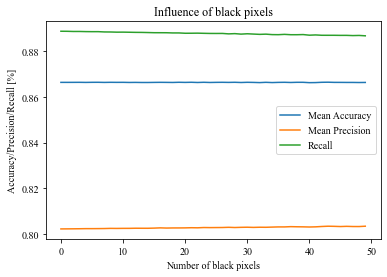

In [420]:
df = pd.read_csv("black_pixels.csv", sep=",")
df = df[['blackpixels','accuracy','precision','recall']].groupby('blackpixels').mean().reset_index()

plt.figure()
plt.plot(df['accuracy'], label='Mean Accuracy')
plt.plot(df['precision'], label='Mean Precision')
plt.plot(df['recall'], label='Recall')
plt.title("Influence of black pixels")
plt.xlabel("Number of black pixels")
plt.ylabel("Accuracy/Precision/Recall [%]")
plt.legend()
plt.savefig('blackpixels.pdf', dpi=600)
plt.show()

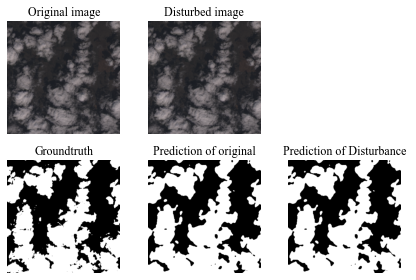

In [423]:
fig, axes = plt.subplots(2, 3)

model.load_weights(MODEL_WEIGHTS[5])

img, mask = files[3]
disturbed_img = black_pixels(img, 100)
og_prediction = model.predict(img.reshape((1, 384, 384, 4)))
prediction = model.predict(disturbed_img.reshape((1, 384, 384, 4)))

axes[0, 0].imshow(img[:, :, :3])
axes[0, 0].set_title('Original image')
axes[0, 0].axis('off')

axes[0, 1].imshow(disturbed_img[:, :, :3])  # Change the colormap as needed
axes[0, 1].set_title('Disturbed image')
axes[0, 1].axis('off')

# Hiding the empty subplot in the second row
axes[0, 2].axis('off')

axes[1, 0].imshow(mask, cmap='gray')  # Change the colormap as needed
axes[1, 0].set_title('Groundtruth')
axes[1, 0].axis('off')

axes[1, 1].imshow(np.where(og_prediction[0] < 0.5, 0, 1), cmap='gray')
axes[1, 1].set_title('Prediction of original')
axes[1, 1].axis('off')

axes[1, 2].imshow(np.where(prediction[0] < 0.5, 0, 1), cmap='gray')
axes[1, 2].set_title('Prediction of Disturbance')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('black_pixels.pdf', dpi=600)
plt.show()

# Dark Current

In [424]:
def dark_current(image, intensity):
    height, width, channels = image.shape[0], image.shape[1], image.shape[2]
    dark_current = np.random.uniform(0, 1, (height, width, channels)) * intensity
    image = np.clip(image + dark_current, 0, 1)
    return image

In [425]:
results = open('dark_current.csv', 'w')
results.write('model,file,intensity,accuracy,precision,recall\n')

for weights in MODEL_WEIGHTS:
    print("[I] Start with weights:", weights)
    model.load_weights(weights)
    
    for file_idx, file in enumerate(files):
        mask = file[1]
        
        for i in range(20):
            img = copy.deepcopy(file[0])
            disturbed_img = dark_current(img, i / 100)
            prediction = model.predict(disturbed_img.reshape((1, 384, 384, 4)))
            prec = precision(mask, prediction)
            rec = recall(mask, prediction)
            acc = overall_accuracy(mask, prediction)
            
            results.write(f'{weights},{image_names[file_idx]},{i / 100},{acc},{prec},{rec}\n')
            
results.close()

[I] Start with weights: weights/weights-24-01-13-18-11.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-13-23-22.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-14-02-33.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-14-05-12.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-14-07-50.hdf5
[I] Start with weights: weights/bc-model-weights-iteration-1-batchsize-8-24-01-14-13-54.hdf5


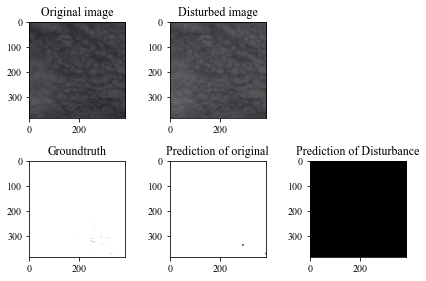

In [452]:
fig, axes = plt.subplots(2, 3)

model.load_weights(MODEL_WEIGHTS[5])

img, mask = files[0]
disturbed_img = dark_current(img, 0.1)
og_prediction = model.predict(img.reshape((1, 384, 384, 4)))
prediction = model.predict(disturbed_img.reshape((1, 384, 384, 4)))

axes[0, 0].imshow(img[:, :, :3])
axes[0, 0].set_title('Original image')

axes[0, 1].imshow(disturbed_img[:, :, :3])  # Change the colormap as needed
axes[0, 1].set_title('Disturbed image')

# Hiding the empty subplot in the second row
axes[0, 2].axis('off')

axes[1, 0].imshow(mask, cmap='gray')  # Change the colormap as needed
axes[1, 0].set_title('Groundtruth')

axes[1, 1].imshow(np.where(og_prediction[0] < 0.5, 0, 1), cmap='gray')
axes[1, 1].set_title('Prediction of original')

axes[1, 2].imshow(np.where(prediction[0] < 0.5, 0, 1), cmap='gray')
axes[1, 2].set_title('Prediction of Disturbance')

plt.tight_layout()
plt.savefig('dark_current.pdf', dpi=600)
plt.show()

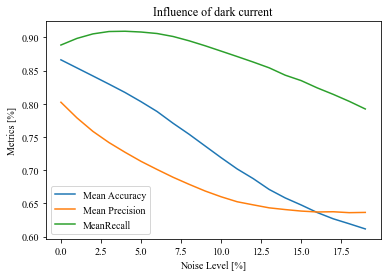

In [455]:
df = pd.read_csv("dark_current.csv", sep=",")
df = df[['intensity','accuracy','precision','recall']].groupby('intensity').mean().reset_index()

plt.figure()
plt.plot(df['accuracy'], label='Mean Accuracy')
plt.plot(df['precision'], label='Mean Precision')
plt.plot(df['recall'], label='MeanRecall')
plt.title("Influence of dark current")
plt.xlabel("Noise Level [%]")
plt.ylabel("Metrics [%]")
plt.legend()
plt.savefig('dark_current.pdf', dpi=600)
plt.show()

## Streaks in the image

In [456]:
def add_streaks_to_image(original_image, num_streaks, streak_length=30):

    # Create a copy of the original image to avoid modifying it
    image_with_streaks = np.copy(original_image)

    for _ in range(num_streaks):
        # Randomly generate streak properties
        streak_angle = np.random.uniform(0, 2*np.pi)  # Angle in radians
        streak_intensity = 1  # Intensity of the streak
        length = streak_length * np.random.rand()
        
        # Calculate the endpoints of the streak
        x1 = np.random.randint(0, image_with_streaks.shape[0])
        y1 = np.random.randint(0, image_with_streaks.shape[1])
        x2 = int(x1 + length * np.cos(streak_angle))
        y2 = int(y1 + length * np.sin(streak_angle))

        # Draw the streak on the image
        cv2.line(image_with_streaks, (x1, y1), (x2, y2), (streak_intensity, streak_intensity, streak_intensity), 1)


    # Ensure pixel values are within [0, 1]
    image_with_streaks[image_with_streaks < 0] = 0
    image_with_streaks[image_with_streaks > 1] = 1

    return image_with_streaks

In [223]:
results = open('streaks.csv', 'w')
results.write('model,file,nbstreaks,accuracy,precision,recall\n')

for weights in MODEL_WEIGHTS:
    print("[I] Start with weights:", weights)
    model.load_weights(weights)
    
    for file_idx, file in enumerate(files):
        mask = file[1]
        
        for i in range(10):
            img = copy.deepcopy(file[0])
            disturbed_img = add_streaks_to_image(img, i)
            prediction = model.predict(disturbed_img.reshape((1, 384, 384, 4)))
            prec = precision(mask, prediction)
            rec = recall(mask, prediction)
            acc = overall_accuracy(mask, prediction)
            
            results.write(f'{weights},{image_names[file_idx]},{i},{acc},{prec},{rec}\n')
            
results.close()

[I] Start with weights: weights/weights-24-01-13-18-11.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-13-23-22.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-14-02-33.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-14-05-12.hdf5
[I] Start with weights: weights/model-weights-iteration1-batchsize-16-24-01-14-07-50.hdf5
[I] Start with weights: weights/bc-model-weights-iteration-1-batchsize-8-24-01-14-13-54.hdf5


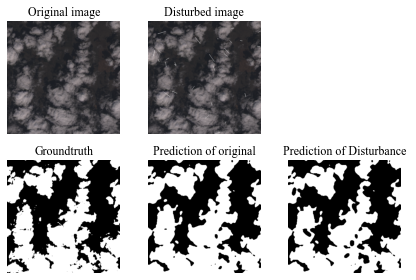

In [457]:
fig, axes = plt.subplots(2, 3)

model.load_weights(MODEL_WEIGHTS[5])

img, mask = files[3]
disturbed_img = add_streaks_to_image(img, 30)
og_prediction = model.predict(img.reshape((1, 384, 384, 4)))
prediction = model.predict(disturbed_img.reshape((1, 384, 384, 4)))

axes[0, 0].imshow(img[:, :, :3])
axes[0, 0].set_title('Original image')
axes[0, 0].axis('off')

axes[0, 1].imshow(disturbed_img[:, :, :3])  # Change the colormap as needed
axes[0, 1].set_title('Disturbed image')
axes[0, 1].axis('off')

# Hiding the empty subplot in the second row
axes[0, 2].axis('off')

axes[1, 0].imshow(mask, cmap='gray')  # Change the colormap as needed
axes[1, 0].set_title('Groundtruth')
axes[1, 0].axis('off')

axes[1, 1].imshow(np.where(og_prediction[0] < 0.5, 0, 1), cmap='gray')
axes[1, 1].set_title('Prediction of original')
axes[1, 1].axis('off')

axes[1, 2].imshow(np.where(prediction[0] < 0.5, 0, 1), cmap='gray')
axes[1, 2].set_title('Prediction of Disturbance')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('radiation_streaks.pdf', dpi=600)
plt.show()

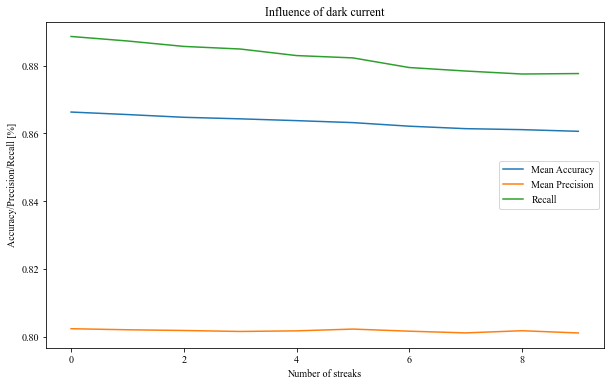

In [459]:
df = pd.read_csv("streaks.csv", sep=",")
df = df[['nbstreaks','accuracy','precision','recall']].groupby('nbstreaks').mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df['accuracy'], label='Mean Accuracy')
plt.plot(df['precision'], label='Mean Precision')
plt.plot(df['recall'], label='Recall')
plt.title("Influence of dark current")
plt.xlabel("Number of streaks")
plt.ylabel("Accuracy/Precision/Recall [%]")
plt.legend()
plt.show()

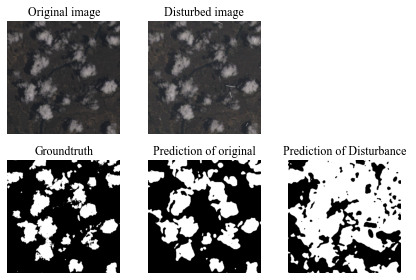

In [531]:
fig, axes = plt.subplots(2, 3)

model.load_weights(MODEL_WEIGHTS[1])

img, mask = files[11]
disturbed_img = hot_pixels(img, 40)
disturbed_img = black_pixels(disturbed_img, 40)
disturbed_img = add_streaks_to_image(disturbed_img, 10)
disturbed_img = dark_current(disturbed_img, 0.08)
og_prediction = model.predict(img.reshape((1, 384, 384, 4)))
prediction = model.predict(disturbed_img.reshape((1, 384, 384, 4)))

axes[0, 0].imshow(img[:, :, :3])
axes[0, 0].set_title('Original image')
axes[0, 0].axis('off')

axes[0, 1].imshow(disturbed_img[:, :, :3])  # Change the colormap as needed
axes[0, 1].set_title('Disturbed image')
axes[0, 1].axis('off')

# Hiding the empty subplot in the second row
axes[0, 2].axis('off')

axes[1, 0].imshow(mask, cmap='gray')  # Change the colormap as needed
axes[1, 0].set_title('Groundtruth')
axes[1, 0].axis('off')

axes[1, 1].imshow(np.where(og_prediction[0] < 0.5, 0, 1), cmap='gray')
axes[1, 1].set_title('Prediction of original')
axes[1, 1].axis('off')

axes[1, 2].imshow(np.where(prediction[0] < 0.5, 0, 1), cmap='gray')
axes[1, 2].set_title('Prediction of Disturbance')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('combined_disturbances.pdf', dpi=600)
plt.show()

# Inject bitflips into Model Weights

- Randomly select weights of the model and inject bit-flips
- Do a layer by layer injection of bit-flips into the network
- Inject different amount of bit-flips

In [533]:
class BitFlipPosition:
    RANDOM = 0
    SIGN_BIT = 1
    EXPONENT_BIT = 2
    MANTISSA_BIT = 3

In [534]:
def perform_bitflip(value: np.float32, position: int = 0) -> Tuple[np.float32, int]:
    float_bytes = struct.pack('f', value)
    bits = list(bin(int.from_bytes(float_bytes, 'little'))[2:].zfill(32))

    flip_index: int = 0
    if position == BitFlipPosition.RANDOM:
        flip_index = random.randint(0, 31)

    elif position == BitFlipPosition.SIGN_BIT:
        flip_index = 0

    elif position == BitFlipPosition.EXPONENT_BIT:
        flip_index = random.randint(1, 8)
        
    elif position == BitFlipPosition.MANTISSA_BIT:
        flip_index = random.randint(9, 31)

    else:
        raise ValueError(f'Position {position} is no part of class BitFlipPosition')

    bits[flip_index] = '1' if bits[flip_index] == '0' else '0'
    return struct.unpack('f', int(''.join(bits), 2).to_bytes(4, 'little'))[0], flip_index

The following analysis is repeated many times. Due to the increased runtime, the analysis is performed on two types of images
- One image with some clouds
- One image with 100% clouds

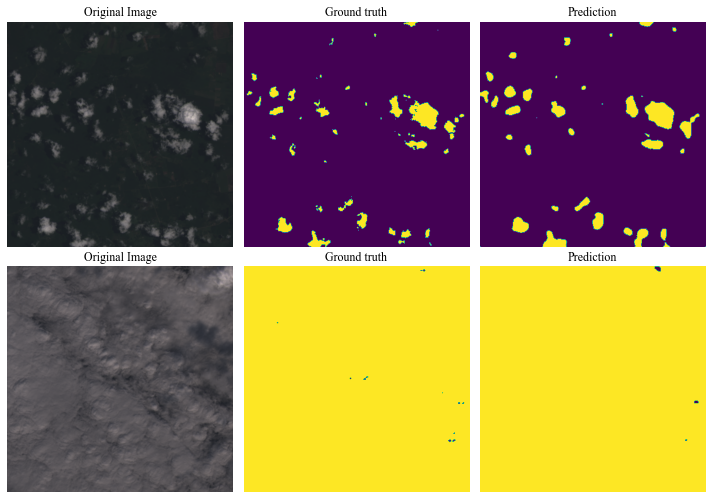

In [565]:
used_files = [files[1], files[10]]
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

for idx, (img, msk) in enumerate(used_files):
    ax[idx, 0].imshow(img[:, :, :3])
    ax[idx, 0].set_title('Original Image')
    ax[idx, 0].axis('off')
    
    ax[idx, 1].imshow(msk)
    ax[idx, 1].set_title('Ground truth')
    ax[idx, 1].axis('off')

    prediction = model.predict(img.reshape((1, 384, 384, 4)))
    ax[idx, 2].imshow(np.where(prediction[0] < 0.5, 0, 1))
    ax[idx, 2].set_title('Prediction')
    ax[idx, 2].axis('off')

plt.tight_layout()
plt.savefig('bitflip_analyzed_images.pdf', dpi=600)
plt.show()

In [583]:
file = open(f'results-{datetime.strftime(datetime.now(), format="%y-%m-%d-%H-%M")}.txt', 'w')
file.write('bitflip,model,layer,layerIdx,iteration,modifiedBit,valueBefore,valueAfter,file,accuracy,precision,recall,jacc\n')
    
for weights in MODEL_WEIGHTS[5:]:
    print("[I] Injection bit-flips in model", weights)
    model.load_weights(weights)
    weights_copy = copy.deepcopy(model.get_weights())

    # Iterate over the layers
    for i in range(len(model.trainable_variables)):
        layer_name = model.trainable_variables[i].name
        
        for bft in [1, 2, 3]:

            # Repeat the experiment several times
            for j in range(2):

                # Copy the weights
                iteration_weights = copy.deepcopy(weights_copy)

                # Weight array of layer i can either be in the shape of (X, ) or (X, X, Y, Z, )
                if len(iteration_weights[i].shape) == 1:
                    flip_idx = random.randint(0, iteration_weights[i].shape[0] - 1)
                    value_before = iteration_weights[i][flip_idx]
                    value_after, modified_bit = perform_bitflip(value_before, bft)
                    iteration_weights[i][flip_idx] = value_after
                elif len(iteration_weights[i].shape) == 4:
                    shape = iteration_weights[i].shape
                    i1, i2, i3, i4 = (random.randint(0, shape[k] - 1) for k in range(4))
                    value_before = iteration_weights[i][i1, i2, i3, i4]
                    value_after, modified_bit = perform_bitflip(value_before, bft)
                    iteration_weights[i][i1, i2, i3, i4] = value_after
                else:
                    raise ValueError(f'Unexpected shape of the model found: {iteration_weights[i].shape}')

                model.set_weights(iteration_weights)

                counter = 0
                imgs = np.array([x[0] for x in used_files])
                msks = np.array([x[1] for x in used_files])

                result = model.predict(imgs)

                for r, m in zip(result, msks):
                    accuracy_val = overall_accuracy(m, r)
                    precision_val = precision(m, r)
                    recall_val = recall(m, r)
                    jacc_val = jacc_coef(m, r)

                    file.write(f'{bft},{weights},{layer_name},{i},{j},{modified_bit},{value_before},{value_after},{counter},{accuracy_val},{precision_val},{recall_val},{jacc_val}\n')
                    counter += 1
file.close()
print("[!] Done")

[I] Injection bit-flips in model weights/bc-model-weights-iteration-1-batchsize-8-24-01-14-13-54.hdf5
[!] Done


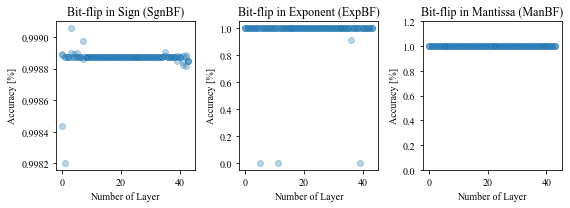

In [584]:
df = pd.read_csv('results-24-01-14-23-29.txt', sep=",")

fig, ax = plt.subplots(1, 3, figsize=(8, 3))

tmp = df[df.bitflip == 1]
ax[0].set_title('Bit-flip in Sign (SgnBF)')
ax[0].scatter(tmp.layerIdx, tmp.accuracy, alpha=0.3)
ax[0].set_xlabel('Number of Layer')
ax[0].set_ylabel('Accuracy [%]')

tmp = df[df.bitflip == 2]
ax[1].set_title('Bit-flip in Exponent (ExpBF)')
ax[1].scatter(tmp.layerIdx, tmp.accuracy, alpha=0.3)
ax[1].set_xlabel('Number of Layer')
ax[1].set_ylabel('Accuracy [%]')

tmp = df[df.bitflip == 3]
ax[2].set_ylim([0, 1.2])
ax[2].set_title('Bit-flip in Mantissa (ManBF)')
ax[2].scatter(tmp.layerIdx, tmp.accuracy, alpha=.3)
ax[2].set_xlabel('Number of Layer')
ax[2].set_ylabel('Accuracy [%]')

plt.tight_layout()
plt.savefig('bitflips.pdf', dpi=600)
plt.show()